### 1. Module import 및 환경 변수 설정

In [1]:
## Import modules
import pandas as pd
import numpy as np

import os
import re
from datetime import datetime, timedelta

### Raw data columns

| 분류 | Node 명 | 의미 | Property 명 | Property 값 | Property의 관계 key 역할 |
|:---|:---|:---|:---|:---|:---|
| 고객 경험 nodes | `CX` | 고객 경험 | CX_ID | 고객 경험 고유 번호 (ex. MA170930FM) | (CX)-[:CX_ID_PREV]-(이전 CX) |
| | | | CX_TYPE | CS유형: 0 = 상담, 1 = 수리, 2 = 교환, 3 = 클레임 | (CX)-[:CX_TYPE]-(CX_TYPE) |
| | | | ETL_LOAD_DATE | ETL적재일시 (datetime format. ex. 2022-10-19 03:45:45) | |
| | | | RCPT_DTHM | CS센터 접수일시 (datetime format. ex. 2022-10-19 03:45:45) | |
| | | | CX_ID_PREV | 동일 고객의 이전 고객 경험 고유 번호 (ex. MA170930FM) | (CX)-[:CX_ID_PREV]-(이전 CX) |
| | | | LABEL_CLAIM_NEXT | 1 = 다음 경험이 CLAIM, 0 = Not | |
| | | | LABEL_CLAIM_FUTURE | 1 = 미래 경험에 CLAIM 발생, 0 = Not | |
| | | | 주간 claim 여부 label들 | 1 = 특정 1주 내 CLAIM 발생, 0 = Not | |
| | | | 이 외, 고객 정보, 제품 정보, 고객 경험 정보들 (아래 참고) | | |
| 고객 정보 nodes | `CUST_NO` | 고객번호 | CUST_NO | 고객 고유 번호 (ex. C000000297, KIOSK00000, Nan) | (CX)-[:CUST_NO]-(CUST_NO) |
| | | | 주간 claim 여부 label들 | 1 = 특정 1주 내 CLAIM 발생, 0 = Not | |
| | `CUST_TYPE` | 고객유형 | CUST_TYPE | 0\~9, A\~Z 중 1 digit | (CX)-[:CUST_TYPE]-(CUST_TYPE) |
| | `VIP_CUST_TYPE` | VIP고객유형 | VIP_CUST_TYPE | A\~Z 중 1 digit | (CX)-[:VIP_CUST_TYPE]-(VIP_CUST_TYPE) |
| | `VIP_GRADE` | VIP등급 | VIP_GRADE | A\~Z 중 1 digit | (CX)-[:VIP_GRADE]-(VIP_GRADE) |
| 제품 정보 nodes | `SERIAL_NO` | 제품 시리얼 번호 | SERIAL_NO | 0\~9, A\~Z의 1\~16 자리 조합 | (CX)-[:SERIAL_NO]-(SERIAL_NO) |
| | `MODEL_CODE` | 제품 모델 코드 | MODEL_CODE | 0\~9, A\~Z 및 '-', ':', '.', ' ', '/' 등 특수 문자의 임의 자리 조합 | (CX)-[:MODEL_CODE]-(MODEL_CODE) |
| | `PRODUCT_CODE` | 제품군 코드 | PRODUCT_CODE | A\~Z의 3\~4 자리 조합 | (CX)-[:PRODUCT_CODE]-(PRODUCT_CODE) |
| 고객 경험 nodes (상담) | `CO_RCPT_CHANNEL` | 접수 채널 | CO_RCPT_CHANNEL | U 등 1개의 영문자 | (CX)-[:CO_RCPT_CHANNEL]-(CO_RCPT_CHANNEL) |
| | `CO_RCPT_USER_ID` | 상담사 ID | CO_RCPT_USER_ID | 0\~9, A\~Z의 6\~7 자리 조합 | (CX)-[:CO_RCPT_USER_ID]-(CO_RCPT_USER_ID) |
| | `CO_RCPT_DEPT_CODE` | 상담사 부서 코드 | CO_RCPT_DEPT_CODE | 12047, PH8002 등 0\~9, A\~Z의 2\~6 자리 조합 | (CX)-[:CO_RCPT_DEPT_CODE]-(CO_RCPT_DEPT_CODE) |
| | `CO_RCPT_WTY_TYPE` | 유무상 구분 | CO_RCPT_WTY_TYPE | M, N, Y 중 하나 | (CX)-[:CO_RCPT_WTY_TYPE]-(CO_RCPT_WTY_TYPE) |
| | `CO_COUNS_LARGE_CLASS` | 상담처리유형대분류 | CO_COUNS_LARGE_CLASS | CL01\~CL36 | (CX)-[:CO_COUNS_LARGE_CLASS]-(CO_COUNS_LARGE_CLASS) |
| | `CO_COUNS_MID_CLASS` | 상담처리유형중분류 | CO_COUNS_MID_CLASS | CM00\~CM4T | (CX)-[:CO_COUNS_MID_CLASS]-(CO_COUNS_MID_CLASS) |
| | `CO_COUNS_SMALL_CLASS` | 상담처리유형소분류 | CO_COUNS_SMALL_CLASS | CS01\~CS22 | (CX)-[:CO_COUNS_SMALL_CLASS]-(CO_COUNS_SMALL_CLASS) |
| | `CO_COUNS_STAT` | 처리 상태 | CO_COUNS_STAT | Z 등 1개의 영문자 | (CX)-[:CO_COUNS_STAT]-(CO_COUNS_STAT) |
| 고객 경험 nodes (수리) | `RP_RCPT_DEPT_TYPE` | 접수처 구분 | RP_RCPT_DEPT_TYPE | A\~Z 1digit 문자 | (CX)-[:RP_RCPT_DEPT_TYPE]-(RP_RCPT_DEPT_TYPE) |
| | `RP_RCPT_USER_ID` | 접수자 ID | RP_RCPT_USER_ID | 0\~9, A\~Z의 4\~7 자리 조합 | (CX)-[:RP_RCPT_USER_ID]-(RP_RCPT_USER_ID) |
| | `RP_REPAIR_SE_ID` | 처리기사 ID | RP_REPAIR_SE_ID | 0\~9, A\~Z의 4\~7 자리 조합 | (CX)-[:RP_REPAIR_SE_ID]-(RP_REPAIR_SE_ID) |
| | `RP_RCPT_TYPE` | 접수 유형 | RP_RCPT_TYPE | 0\~9, A\~Z의 한 문자 | (CX)-[:RP_RCPT_TYPE]-(RP_RCPT_TYPE) |
| | `RP_RCPT_WTY_TYPE` | 접수 유무상 여부 | RP_RCPT_WTY_TYPE | M, N, Y 중 하나 | (CX)-[:RP_RCPT_WTY_TYPE]-(RP_RCPT_WTY_TYPE) |
| | `RP_RCPT_SYMP_CODE` | 접수 증상 코드1 | RP_RCPT_SYMP_CODE | 0\~9, A\~Z의 11\~14 자리 조합 | (CX)-[:RP_RCPT_SYMP_CODE]-(RP_RCPT_SYMP_CODE) |
| | `RP_RCPT_SUB_SYMP_CODE` | 접수 증상 코드2 | RP_RCPT_SUB_SYMP_CODE | 0\~9, A\~Z의 7\~8 자리 조합 | (CX)-[:RP_RCPT_SUB_SYMP_CODE]-(RP_RCPT_SUB_SYMP_CODE) |
| | `RP_FAIL_CODE_GROUP` | 고장 그룹 코드 | RP_FAIL_CODE_GROUP | ACL 등 A\~Z의 3 자리 조합 | (CX)-[:RP_FAIL_CODE_GROUP]-(RP_FAIL_CODE_GROUP) |
| | `RP_FAIL_LARGE_CLASS` | 고장 대분류 | RP_FAIL_LARGE_CLASS | 1B, ZZ 등 0\~9, A\~Z의 2 자리 조합 | (CX)-[:RP_FAIL_LARGE_CLASS]-(RP_FAIL_LARGE_CLASS) |
| | `RP_FAIL_MID_CLASS` | 고장 중분류 | RP_FAIL_MID_CLASS | 0\~9, A\~Z의 3 자리 조합 | (CX)-[:RP_FAIL_MID_CLASS]-(RP_FAIL_MID_CLASS) |
| | `RP_FAIL_REASON_CODE` | 고장 원인 코드 | RP_FAIL_REASON_CODE | A\~Z의 3 자리 조합 | (CX)-[:RP_FAIL_REASON_CODE]-(RP_FAIL_REASON_CODE) |
| | `RP_FAIL_TYPE` | 고장 유형 | RP_FAIL_TYPE | 1.0\~9.0 중 한 정수 | (CX)-[:RP_FAIL_TYPE]-(RP_FAIL_TYPE) |
| | `RP_REPAIR_WTY_TYPE` | 유무상 수리 유형 | RP_REPAIR_WTY_TYPE | M, Y, Z 중 하나 | (CX)-[:RP_REPAIR_WTY_TYPE]-(RP_REPAIR_WTY_TYPE) |
| | `RP_TOTAL_FEE_AMT` | 수수료 합 | RP_TOTAL_FEE_AMT | 0: 0원 이하, 1: 5만원 미만, 2: 10만원 미만, 3: 50만원 미만, 4: 100만원 미만, 5: 100만원 이상 | (CX)-[:RP_TOTAL_FEE_AMT]-(RP_TOTAL_FEE_AMT) |
| | `RP_TOTAL_AMT` | 합계 금액 | RP_TOTAL_AMT | 0: 0원 이하, 1: 5만원 미만, 2: 10만원 미만, 3: 50만원 미만, 4: 100만원 미만, 5: 100만원 이상 | (CX)-[:RP_TOTAL_AMT]-(RP_TOTAL_AMT) |
| | `RP_STATUS` | 서비스 상태 | RP_STATUS | 0, 1, 2, 3 중 하나 | (CX)-[:RP_STATUS]-(RP_STATUS) |
| | `RP_UNSATIS_ETD_TYPE1` | 불만 잠재 유형1 | RP_UNSATIS_ETD_TYPE1 | 1.0\~5.0 중 한 정수 | (CX)-[:RP_UNSATIS_ETD_TYPE1]-(RP_UNSATIS_ETD_TYPE1) |
| | `RP_UNSATIS_ETD_TYPE2` | 불만 잠재 유형2 | RP_UNSATIS_ETD_TYPE2 | 1\~5, A, E 중 하나 | (CX)-[:RP_UNSATIS_ETD_TYPE2]-(RP_UNSATIS_ETD_TYPE2) |
| | `RP_RE_REPAIR_TYPE` | 다빈도 고장 유형 | RP_RE_REPAIR_TYPE | A, B, C, N, Y 중 하나 | (CX)-[:RP_RE_REPAIR_TYPE]-(RP_RE_REPAIR_TYPE) |
| 고객 경험 nodes (교환 환불) | `EX_AGENT_CODE` | 대리점코드 - 교환/환불 실행 대리점 | EX_AGENT_CODE | 0\~9, A\~Z 및 '-'의 8\~19 자리 조합 | (CX)-[:EX_AGENT_CODE]-(EX_AGENT_CODE) |
| | `EX_CAUSE_CODE` | 교환환불사유코드 | EX_CAUSE_CODE | 0\~9, A\~Z의 3 자리 조합 | (CX)-[:EX_CAUSE_CODE]-(EX_CAUSE_CODE) |
| | `EX_BUY_FACTOR_CODE` | 대체품 구매 의향 | EX_BUY_FACTOR_CODE | A, B, A1\~A6 중 하나 | (CX)-[:EX_BUY_FACTOR_CODE]-(EX_BUY_FACTOR_CODE) |
| | `EX_EXCHANGE_ORDER_TYPE` | 교환환불 유형 | EX_EXCHANGE_ORDER_TYPE | A\~Z의 3 자리 조합 | (CX)-[:EX_EXCHANGE_ORDER_TYPE]-(EX_EXCHANGE_ORDER_TYPE) |
| | `EX_COMPLETE_YN` | 교환환불완료여부 | EX_COMPLETE_YN | N, Y 중 하나 | (CX)-[:EX_COMPLETE_YN]-(EX_COMPLETE_YN) |
| 고객 경험 nodes (클레임) | `CL_CLAIM_RCPT_CHANNEL` | 클레임 접수 채널 | CL_CLAIM_RCPT_CHANNEL | A\~Z 중 한 문자 | (CX)-[:CL_CLAIM_RCPT_CHANNEL]-(CL_CLAIM_RCPT_CHANNEL) |
| | `CL_CLAIM_RCPT_TYPE` | 클레임 접수 유형 | CL_CLAIM_RCPT_TYPE | 1, 2, 3, 4 중 하나 | (CX)-[:CL_CLAIM_RCPT_TYPE]-(CL_CLAIM_RCPT_TYPE) |
| | `CL_RCPT_DEPT_CODE` | 접수 부서 코드 | CL_RCPT_DEPT_CODE | 0\~9의 2\~5 자리 조합 | (CX)-[:CL_RCPT_DEPT_CODE]-(CL_RCPT_DEPT_CODE) |
| | `CL_RCPT_USER_ID` | 접수원 ID | CL_RCPT_USER_ID | 0\~9, A\~Z의 6\~7 자리 조합 | (CX)-[:CL_RCPT_USER_ID]-(CL_RCPT_USER_ID) |
| | `CL_CLAIM_TYPE` | 클레임 유형 | CL_CLAIM_TYPE | A, B, C, D, Z 중 하나 | (CX)-[:CL_CLAIM_TYPE]-(CL_CLAIM_TYPE) |
| | `CL_CLAIM_LARGE_CLASS` | 클레임 대분류 | CL_CLAIM_LARGE_CLASS | VG01\~VG65 | (CX)-[:CL_CLAIM_LARGE_CLASS]-(CL_CLAIM_LARGE_CLASS) |
| | `CL_CLAIM_MID_CLASS` | 클레임 중분류 | CL_CLAIM_MID_CLASS | VM01\~VM26 | (CX)-[:CL_CLAIM_MID_CLASS]-(CL_CLAIM_MID_CLASS) |
| | `CL_CLAIM_SMALL_CLASS` | 클레임 소분류 | CL_CLAIM_SMALL_CLASS | VS01\~VS35 | (CX)-[:CL_CLAIM_SMALL_CLASS]-(CL_CLAIM_SMALL_CLASS) |
| | `CL_SYMP_CODE` | 증상 코드 | CL_SYMP_CODE | `전부 Nan` | (CX)-[:CL_SYMP_CODE]-(CL_SYMP_CODE) |
| | `CL_DETAIL_SYMP_CODE` | 세부 증상 코드 | CL_DETAIL_SYMP_CODE | `전부 Nan` | (CX)-[:CL_DETAIL_SYMP_CODE]-(CL_DETAIL_SYMP_CODE) |
| | `CL_TGET_SECTION` | 귀책 부문 | CL_TGET_SECTION | A, B, C 중 하나 | (CX)-[:CL_TGET_SECTION]-(CL_TGET_SECTION) |
| | `CL_TGET_DEPT_CODE` | 귀책 부서 | CL_TGET_DEPT_CODE | 0\~9, A\~Z의 3\~8 자리 조합 | (CX)-[:CL_TGET_DEPT_CODE]-(CL_TGET_DEPT_CODE) |
| | `CL_CUST_REQ_TYPE` | 고객 요구 유형 | CL_CUST_REQ_TYPE | 1\~15 중 한 정수 | (CX)-[:CL_CUST_REQ_TYPE]-(CL_CUST_REQ_TYPE) |
| | `CL_PRCS_TYPE` | 처리 유형 | CL_PRCS_TYPE | A\~Z 중 한 문자 | (CX)-[:CL_PRCS_TYPE]-(CL_PRCS_TYPE) |
| | `CL_CLAIM_WTY_TYPE` | 유무상 구분 | CL_CLAIM_WTY_TYPE | M, N, Y 중 하나 | (CX)-[:CL_CLAIM_WTY_TYPE]-(CL_CLAIM_WTY_TYPE) |
| | `CL_CLAIM_STATUS` | 클레임 상태 | CL_CLAIM_STATUS | 3, 4 중 하나 | (CX)-[:CL_CLAIM_STATUS]-(CL_CLAIM_STATUS) |
| | `CL_SATIS_TYPE` | 만족 불만족 | CL_SATIS_TYPE | `전부 Nan` | (CX)-[:CL_SATIS_TYPE]-(CL_SATIS_TYPE) |

### 2. Raw data EDA (Exploratory Data Analysis)

#### Raw data load

In [2]:
df = pd.read_csv('raw_data.csv')

/home/sookyoung.kim/ssd/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (2,3,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,39,40,43,44,45,46,47,48,51,52,53,54,55,58,59,61,62) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


#### Raw data의 column 구조와 값들 살펴보기

In [3]:
df.head()

,CUST_NO,CUST_TYPE,VIP_CUST_TYPE,VIP_GRADE,SERIAL_NO,MODEL_CODE,PRODUCT_CODE,CX_ID,CX_TYPE,ETL_LOAD_DATE,...,CL_TGET_SECTION,CL_TGET_DEPT_CODE,CL_CUST_REQ_TYPE,CL_PRCS_TYPE,CL_CLAIM_WTY_TYPE,CL_CLAIM_STATUS,CL_SATIS_TYPE,LABEL_CLAIM_INF,FLAG_TRAIN_INFER,CX_CNT
0,C000002735,E,NaN,NaN,NaN,65UM7900BNA.AKRYLH,LCL,J052975145,0,20230128035021,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2,3
1,C000002735,E,NaN,NaN,NaN,65UM7900BNA.AKRYLH,LCL,J052976408,0,20230128035035,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2,3
2,C000002735,E,NaN,NaN,NaN,65UM7900BNA.AKRYLH,LCL,J052977067,0,20230128035021,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2,3
3,C000002881,A,NaN,NaN,NaN,R-T863VJCWU.AKOR,SBS,J053322769,0,20230310200947,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2,2
4,C000002881,A,NaN,NaN,310KRLR2S904,R-T863VJCWU.AKOR,SBS,N2231314YM,1,20230331185418,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2,2


In [4]:
df.tail()

,CUST_NO,CUST_TYPE,VIP_CUST_TYPE,VIP_GRADE,SERIAL_NO,MODEL_CODE,PRODUCT_CODE,CX_ID,CX_TYPE,ETL_LOAD_DATE,...,CL_TGET_SECTION,CL_TGET_DEPT_CODE,CL_CUST_REQ_TYPE,CL_PRCS_TYPE,CL_CLAIM_WTY_TYPE,CL_CLAIM_STATUS,CL_SATIS_TYPE,LABEL_CLAIM_INF,FLAG_TRAIN_INFER,CX_CNT
1224974,C04181588,A,NaN,NaN,303KWKS1W493,FX25GSG.AKOR,DRW,D001182316,2,20230402055344,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,4
1224975,C089550550,A,NaN,NaN,301INGQ53191,OLED77C2SNC.AKRQLJD,LCL,D001184316,2,20230402055345,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,3
1224976,C109288664,A,NaN,NaN,910RBEZ3D308,K224LW11E.AKOR,KRE,D001180116,2,20230402055343,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,3
1224977,C109323697,A,NaN,NaN,301NTTQFK977,32QN650-BB.BKRDMSN,MNT,D001183316,2,20230402055345,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,2
1224978,C109397741,A,NaN,NaN,510KCYQ5H626,55EG9370-NB.AKRZLH,LCL,D001190616,2,20230402055344,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,4


In [5]:
len(df)

1224979

#### 결측치를 포함한 samples (행) 제거해 보기

In [6]:
df1 = df.copy()

In [7]:
df1.dropna(inplace=True)

In [8]:
len(df1)

0

### 3. Data Preprocessing

#### 결측치가 없는 column들 찾기

In [9]:
column_list = df.columns.to_list()
print(column_list)

['CUST_NO', 'CUST_TYPE', 'VIP_CUST_TYPE', 'VIP_GRADE', 'SERIAL_NO', 'MODEL_CODE', 'PRODUCT_CODE', 'CX_ID', 'CX_TYPE', 'ETL_LOAD_DATE', 'RCPT_DTHM', 'CX_ID_PREV', 'LABEL_CLAIM', 'CO_BUY_DT', 'CO_RCPT_CHANNEL', 'CO_RCPT_USER_ID', 'CO_RCPT_DEPT_CODE', 'CO_RCPT_WTY_TYPE', 'CO_COUNS_LARGE_CLASS', 'CO_COUNS_MID_CLASS', 'CO_COUNS_SMALL_CLASS', 'CO_COUNS_STAT', 'RP_RCPT_DEPT_TYPE', 'RP_RCPT_USER_ID', 'RP_REPAIR_SE_ID', 'RP_RCPT_TYPE', 'RP_RCPT_WTY_TYPE', 'RP_RCPT_SYMP_CODE', 'RP_RCPT_SUB_SYMP_CODE', 'RP_FAIL_CODE_GROUP', 'RP_FAIL_LARGE_CLASS', 'RP_FAIL_MID_CLASS', 'RP_FAIL_REASON_CODE', 'RP_FAIL_TYPE', 'RP_REPAIR_WTY_TYPE', 'RP_TOTAL_FEE_AMT', 'RP_TOTAL_AMT', 'RP_STATUS', 'RP_UNSATIS_ETD_TYPE1', 'RP_UNSATIS_ETD_TYPE2', 'RP_RE_REPAIR_TYPE', 'EX_REPAIR_DT', 'EX_COMPLETE_DT', 'EX_AGENT_CODE', 'EX_CAUSE_CODE', 'EX_BUY_FACTOR_CODE', 'EX_EXCHANGE_ORDER_TYPE', 'EX_COMPLETE_YN', 'CL_CLAIM_RCPT_CHANNEL', 'CL_CLAIM_RCPT_TYPE', 'CL_RCPT_DEPT_CODE', 'CL_RCPT_USER_ID', 'CL_CLAIM_TYPE', 'CL_CLAIM_LARGE_CLAS

In [10]:
no_missing_column_list = []

for i in column_list:
    missing_no = df[i].isnull().sum()
    print("Column {} includes {} missings".format(i, missing_no))
    if missing_no == 0:
        no_missing_column_list.append(i)

print("No missing columns = {}".format(no_missing_column_list))

Column CUST_NO includes 0 missings
Column CUST_TYPE includes 208 missings
Column VIP_CUST_TYPE includes 1224043 missings
Column VIP_GRADE includes 1224043 missings
Column SERIAL_NO includes 649138 missings
Column MODEL_CODE includes 366098 missings
Column PRODUCT_CODE includes 265 missings
Column CX_ID includes 0 missings
Column CX_TYPE includes 0 missings
Column ETL_LOAD_DATE includes 0 missings
Column RCPT_DTHM includes 0 missings
Column CX_ID_PREV includes 336655 missings
Column LABEL_CLAIM includes 0 missings
Column CO_BUY_DT includes 1224979 missings
Column CO_RCPT_CHANNEL includes 662003 missings
Column CO_RCPT_USER_ID includes 655874 missings
Column CO_RCPT_DEPT_CODE includes 655874 missings
Column CO_RCPT_WTY_TYPE includes 686408 missings
Column CO_COUNS_LARGE_CLASS includes 706034 missings
Column CO_COUNS_MID_CLASS includes 706509 missings
Column CO_COUNS_SMALL_CLASS includes 706761 missings
Column CO_COUNS_STAT includes 655874 missings
Column RP_RCPT_DEPT_TYPE includes 579430

#### 결측치 없는 column들만으로 새로운 data file 생성

In [11]:
df1 = pd.DataFrame()

for i in no_missing_column_list:
    df1[i] = df[i]

In [42]:
df1.drop_duplicates(['CUST_NO'], keep='last', inplace=True)

In [43]:
df1.head()

,CUST_NO,CX_ID,CX_TYPE,ETL_LOAD_DATE,RCPT_DTHM,LABEL_CLAIM,LABEL_CLAIM_INF,FLAG_TRAIN_INFER,CX_CNT
2,C000002735,J052977067,0,20230128035021,20230127115000,0,0,2,3
4,C000002881,N2231314YM,1,20230331185418,20230223131400,0,0,2,2
7,C000003470,J053109659,0,20230208035659,20230207095200,0,0,2,3
10,C00000856,N1311100XU,1,20230201053554,20230131110000,0,0,2,3
12,C000008746,N1131438DY,1,20230117053714,20230113143800,0,0,2,2


#### 결측치 없는 column들만 남긴 raw data를 train set과 inference set으로 나누기

In [44]:
cond = df1.loc[:, 'FLAG_TRAIN_INFER'] != 1

df1_train = df1.loc[cond, :]

In [45]:
len(df1_train)

412629

In [46]:
df1_train.tail()

,CUST_NO,CX_ID,CX_TYPE,ETL_LOAD_DATE,RCPT_DTHM,LABEL_CLAIM,LABEL_CLAIM_INF,FLAG_TRAIN_INFER,CX_CNT
1224415,C109126292,D001182337,2,20230326055656,20230325100000,0,0,2,2
1224416,C096647008,D001182717,2,20230326055658,20230325100000,0,0,2,3
1224417,C095239695,D001183977,2,20230326055658,20230325100000,0,0,2,3
1224418,C107658041,D001179597,2,20230326055656,20230325100000,0,0,2,2
1224419,C104172992,D001182218,2,20230327055844,20230326100000,0,0,2,4


In [47]:
cond = df1.loc[:, 'FLAG_TRAIN_INFER'] != 0

df1_infer = df1.loc[cond, :]

In [48]:
len(df1_infer)

451670

In [49]:
df1_infer.tail()

,CUST_NO,CX_ID,CX_TYPE,ETL_LOAD_DATE,RCPT_DTHM,LABEL_CLAIM,LABEL_CLAIM_INF,FLAG_TRAIN_INFER,CX_CNT
1224974,C04181588,D001182316,2,20230402055344,20230401100000,1,0,1,4
1224975,C089550550,D001184316,2,20230402055345,20230401100000,0,0,1,3
1224976,C109288664,D001180116,2,20230402055343,20230401100000,0,0,1,3
1224977,C109323697,D001183316,2,20230402055345,20230401100000,0,0,1,2
1224978,C109397741,D001190616,2,20230402055344,20230401100000,0,0,1,4


### 4. Down sampling (Negative sampling)

#### Train set과 inference set 간 claim/noclaim 샘플들 간 유사도 확인

In [64]:
!pip unistall umap
!pip install umap-learn

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
ERROR: unknown command "unistall" - maybe you meant "uninstall"
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.8/90.8 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pynndescent-0.5.10.tar.gz (1.1 MB)
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for tbb>=2019.0 from https://files.pythonhosted.org/packages/79/a8/01ac205ff1f68f543aa73d69d6947218cd0973992a4b60cf0a4bfe507561/tbb-2021.10.0-py2.py3-none-manylinux1_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 20.5 MB/s eta 0:00:0000:0100:01
  Created wheel for umap-learn: filename=umap_

Train set과 inference set의 label 1과 0인 sample들을 추출

In [50]:
df1_train_infer = df1.copy()

# Train set의 label 0인 samples
cond_tmp = (df1_train_infer.loc[:, 'FLAG_TRAIN_INFER'] != 1) & (df1_train_infer.loc[:, 'LABEL_CLAIM'] == 0)
df_train_noclaim = df1_train_infer.loc[cond_tmp, :]

# Train set의 label 1인 samples
cond_tmp = (df1_train_infer.loc[:, 'FLAG_TRAIN_INFER'] != 1) & (df1_train_infer.loc[:, 'LABEL_CLAIM'] == 1)
df_train_claim = df1_train_infer.loc[cond_tmp, :]

# Inference set의 label 0인 samples
cond_tmp = (df1_train_infer.loc[:, 'FLAG_TRAIN_INFER'] != 0) & (df1_train_infer.loc[:, 'LABEL_CLAIM'] == 0)
df_train_noclaim = df1_train_infer.loc[cond_tmp, :]

# Inference set의 label 1인 samples
cond_tmp = (df1_train_infer.loc[:, 'FLAG_TRAIN_INFER'] != 0) & (df1_train_infer.loc[:, 'LABEL_CLAIM'] == 1)
df_train_claim = df1_train_infer.loc[cond_tmp, :]

# Train과 inference set의 label 0인 samples
cond_tmp = (df1_train_infer.loc[:, 'LABEL_CLAIM'] == 0)
df_train_infer_noclaim = df1_train_infer.loc[cond_tmp, :]

# Train과 inference set의 label 1인 samples
cond_tmp = (df1_train_infer.loc[:, 'LABEL_CLAIM'] == 1)
df_train_infer_claim = df1_train_infer.loc[cond_tmp, :]

In [51]:
import umap.umap_ as umap

# UMAP dimension reduction from 4 to 2
def umap_dimension_reduction_d4_to_d2(df_h, n_neighbors, min_dist, metric, output_df_col_list):
        
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=2, metric=metric, verbose=True)
       
    list_header = ['CX_TYPE', 'ETL_LOAD_DATE', 'RCPT_DTHM', 'CX_CNT']
    
    hd_vector_data = df_h[list_header].values
    ld_vector_data = reducer.fit_transform(hd_vector_data)
    
    df_l = pd.DataFrame(data = ld_vector_data.tolist(), columns = output_df_col_list, index=df_h.index)
    
    return df_l

Train set과 inference set의 label 1 samples 비교

- 서로 겹치는 분포를 가져야 train set학습한 모델로 inference set을 잘 예측할 수 있을 것

In [52]:
df2 = df_train_infer_claim.copy()

# Plotting 전에 X 변수들만 남김
df2.drop(['CUST_NO'], axis=1, inplace=True)
df2.drop(['FLAG_TRAIN_INFER'], axis=1, inplace=True)
df2.drop(['LABEL_CLAIM'], axis=1, inplace=True)
df2.drop(['LABEL_CLAIM_INF'], axis=1, inplace=True)

# UMAP을 이용한 차원 축소 (4차원 -> 2차원)
df2_ld = umap_dimension_reduction_d4_to_d2(df2, 50, 0.1, 'euclidean', ['D1','D2'])

# Train / inference sample 구분을 위해 flag를 다시 붙여 줌
df2_ld['FLAG_TRAIN_INFER'] = df_train_infer_claim['FLAG_TRAIN_INFER']

UMAP(n_neighbors=50, verbose=True)
Tue Nov 14 04:41:00 2023 Construct fuzzy simplicial set
Tue Nov 14 04:41:00 2023 Finding Nearest Neighbors
Tue Nov 14 04:41:00 2023 Finished Nearest Neighbor Search
Tue Nov 14 04:41:00 2023 Construct embedding


/home/sookyoung.kim/.local/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Tue Nov 14 04:41:03 2023 Finished embedding


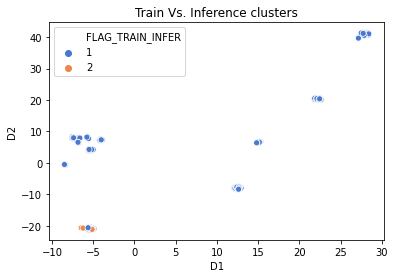

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(data=df2_ld, 
                x='D1', y='D2', 
                hue='FLAG_TRAIN_INFER', palette='muted').set_title('Train Vs. Inference clusters');
#plt.ylim(-10, 20)
#plt.xlim(-4, 14)

=> 분포가 서로 겹치지 않으므로, train set으로 학습한 모델의 inference set에 대한 예측 성능이 좋지 못할 것이 예상됨

Train set의 label 0과 1 samples 비교

- 서로 겹치지 않는 분포를 가져야 classification 모델 학습이 용이할 것

In [54]:
df2 = df1_train.copy()

# Plotting 전에 X 변수들만 남김
df2.drop(['CUST_NO'], axis=1, inplace=True)
df2.drop(['FLAG_TRAIN_INFER'], axis=1, inplace=True)
df2.drop(['LABEL_CLAIM'], axis=1, inplace=True)
df2.drop(['LABEL_CLAIM_INF'], axis=1, inplace=True)

# UMAP을 이용한 차원 축소 (4차원 -> 2차원)
df2_ld = umap_dimension_reduction_d4_to_d2(df2, 50, 0.1, 'euclidean', ['D1','D2'])

# Label 0 1 구분을 위해 label을 다시 붙여 줌
df2_ld['LABEL_CLAIM'] = df1_train['LABEL_CLAIM']

UMAP(n_neighbors=50, verbose=True)
Tue Nov 14 04:41:19 2023 Construct fuzzy simplicial set
Tue Nov 14 04:41:19 2023 Finding Nearest Neighbors
Tue Nov 14 04:41:19 2023 Building RP forest with 37 trees
Tue Nov 14 04:41:20 2023 NN descent for 19 iterations
	 1  /  19
	 2  /  19
	Stopping threshold met -- exiting after 2 iterations
Tue Nov 14 04:42:34 2023 Finished Nearest Neighbor Search
Tue Nov 14 04:42:46 2023 Construct embedding


/home/sookyoung.kim/.local/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Tue Nov 14 05:12:10 2023 Finished embedding


/home/sookyoung.kim/ssd/anaconda3/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/sookyoung.kim/ssd/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


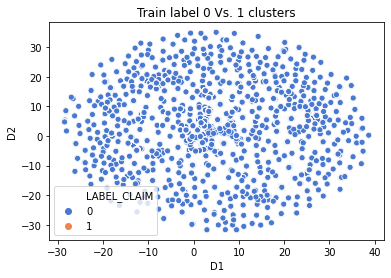

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(data=df2_ld, 
                x='D1', y='D2', 
                hue='LABEL_CLAIM', palette='muted').set_title('Train label 0 Vs. 1 clusters');
#plt.ylim(-10, 20)
#plt.xlim(-4, 14)

=> 분포가 서로 겹치므로, classification 모델 학습이 용이하지 않을 것이 예상됨

=> 문제 완화를 위한 한 가지 방법은 negative sampling

#### Negative Sampling

Train set 내의 claim samples의 자신들의 centroid로부터의 거리

In [56]:
#from sklearn.neighbors.nearest_centroid import NearestCentroid
import math

list_dimensions = ['CX_TYPE', 'ETL_LOAD_DATE', 'RCPT_DTHM', 'CX_CNT']
# Claim samples의 centroid 찾기
list_train_claim_centroid = df_train_claim[list_dimensions].mean().to_list()
train_claim_centroid = np.array(list_train_claim_centroid)
#print(list_train_claim_centroid)
#print(sum(list_train_claim_centroid) / len(list_train_claim_centroid))

# Noclaim samples와의 거리 계산
df_train_claim_dist = df_train_claim[list_dimensions]
df_train_claim_dist['DIST'] = df_train_claim_dist.sub(train_claim_centroid, axis=1).pow(2).sum(axis=1).pow(.5)

train_claim_dist_max = df_train_claim_dist['DIST'].max()
train_claim_dist_min = df_train_claim_dist['DIST'].min()
print(train_claim_dist_max, train_claim_dist_min)

df_train_claim_dist['CUST_NO'] = df_train_claim['CUST_NO']
df_train_claim_dist['CX_TYPE'] = df_train_claim['CX_TYPE']
df_train_claim_dist['FLAG_TRAIN_INFER'] = df_train_claim['FLAG_TRAIN_INFER']
df_train_claim_dist['LABEL_CLAIM'] = df_train_claim['LABEL_CLAIM']
df_train_claim_dist['LABEL_CLAIM_INF'] = df_train_claim['LABEL_CLAIM_INF']
df_train_claim_dist['RCPT_DTHM'] = df_train_claim['RCPT_DTHM']

#df_train_claim_dist = df_train_claim_dist.sort_values(by=['DIST'], ascending=False)
df_train_claim_dist = df_train_claim_dist.sort_values(by=['DIST'], ascending=True)
print(df_train_claim_dist['DIST'])
df_train_claim_dist.reset_index(drop=True, inplace=True)
#df_train_claim_dist.drop(['DIST'], axis=1, inplace=True)

# Down sampling noclaim
len_train_claim = len(df_train_claim)
print(len_train_claim)

196143346.32268798 31601672.720048115
1171316    3.160167e+07
1224830    3.167132e+07
1224827    3.167132e+07
490273     3.169137e+07
576017     3.169266e+07
               ...     
646889     8.079998e+07
338902     8.499837e+07
1221477    1.849032e+08
1221290    1.877137e+08
1220830    1.961433e+08
Name: DIST, Length: 236, dtype: float64
236


/home/sookyoung.kim/.local/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/sookyoung.kim/.local/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/sookyoung.kim/.local/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

Train set 내의 noclaim samples의 claim samples centroid로부터의 거리

In [57]:
import math

### Euclidean distance

# Claim samples의 centroid 찾기
list_train_claim_centroid = df_train_claim[list_dimensions].mean().to_list()
train_claim_centroid = np.array(list_train_claim_centroid)

# Noclaim samples와의 거리 계산
df_train_noclaim_dist = df_train_noclaim[list_dimensions]
df_train_noclaim_dist['DIST'] = df_train_noclaim_dist.sub(train_claim_centroid, axis=1).pow(2).sum(axis=1).pow(.5)

df_train_noclaim_dist['CUST_NO'] = df_train_noclaim['CUST_NO']
df_train_noclaim_dist['CX_TYPE'] = df_train_noclaim['CX_TYPE']
df_train_noclaim_dist['FLAG_TRAIN_INFER'] = df_train_noclaim['FLAG_TRAIN_INFER']
df_train_noclaim_dist['LABEL_CLAIM'] = df_train_noclaim['LABEL_CLAIM']
df_train_noclaim_dist['LABEL_CLAIM_INF'] = df_train_noclaim['LABEL_CLAIM_INF']
df_train_noclaim_dist['RCPT_DTHM'] = df_train_noclaim['RCPT_DTHM']

df_train_noclaim_dist_gt = df_train_noclaim_dist.sort_values(by=['DIST'], ascending=False)
df_train_noclaim_dist_lt = df_train_noclaim_dist.sort_values(by=['DIST'], ascending=True)
print(df_train_noclaim_dist_gt['DIST'])
df_train_noclaim_dist_gt.reset_index(drop=True, inplace=True)
print(df_train_noclaim_dist_lt['DIST'])
df_train_noclaim_dist_lt.reset_index(drop=True, inplace=True)

# Down sampling noclaim
len_train_claim = len(df_train_claim)
print(len_train_claim)

if 1:
    df_train_noclaim_undersamples_lt = df_train_noclaim_dist_lt.iloc[0:round(len_train_claim*2.5),:]
    df_train_noclaim_undersamples_gt = df_train_noclaim_dist_gt.iloc[0:round(len_train_claim*2.5),:]
else:
    cond_tmp = df_train_noclaim_dist.loc[:, 'DIST'] < train_claim_dist_min
    df_train_noclaim_undersamples_lt = \
        df_train_noclaim_dist.loc[cond_tmp, :].sort_values(by=['DIST'], ascending=False).iloc[0:round(len_train_claim*1.5),:]
    cond_tmp = df_train_noclaim_dist.loc[:, 'DIST'] > train_claim_dist_max
    df_train_noclaim_undersamples_gt = \
        df_train_noclaim_dist.loc[cond_tmp, :].sort_values(by=['DIST'], ascending=True).iloc[0:round(len_train_claim*1.5),:]

df_train_noclaim_undersamples = pd.concat([df_train_noclaim_undersamples_lt, df_train_noclaim_undersamples_gt], ignore_index=True)

df_train_noclaim_undersamples.drop(['DIST'], axis=1, inplace=True)

# Make up the train set
df_train_undersamples = pd.concat([df_train_claim, df_train_noclaim_undersamples], ignore_index=True)
#print(df_train_noclaim_undersamples)
#print(df_train_undersamples)
#df_train_undersamples.to_csv('vectors_CUST_NO_under.csv')

/home/sookyoung.kim/.local/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/sookyoung.kim/.local/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/sookyoung.kim/.local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

598522     3.371785e+08
618794     3.371770e+08
293437     3.371769e+08
449355     3.371746e+08
789426     3.371732e+08
               ...     
177194     3.151037e+07
1151103    3.151036e+07
1152368    3.151036e+07
1174318    3.151036e+07
572565     3.151036e+07
Name: DIST, Length: 451434, dtype: float64
572565     3.151036e+07
1174318    3.151036e+07
1152368    3.151036e+07
1151103    3.151036e+07
177194     3.151037e+07
               ...     
789426     3.371732e+08
449355     3.371746e+08
293437     3.371769e+08
618794     3.371770e+08
598522     3.371785e+08
Name: DIST, Length: 451434, dtype: float64
236


### 5. Light GBM model learning

In [58]:
df_train_undersamples.head()

,CUST_NO,CX_ID,CX_TYPE,ETL_LOAD_DATE,RCPT_DTHM,LABEL_CLAIM,LABEL_CLAIM_INF,FLAG_TRAIN_INFER,CX_CNT
0,C001486251,B001014711,3,20230404014334,20230331154100,1,0,1,9
1,C001769715,B001013751,3,20230331013912,20230329165900,1,0,1,4
2,C002411644,B001012975,3,20230330035401,20230328100700,1,0,1,2
3,C005151581,B001014132,3,20230401014008,20230330123300,1,0,1,5
4,C007322387,N3301041FV,1,20230405053654,20230330104100,1,0,1,8


In [63]:
import lightgbm as lgbm
from sklearn.model_selection import train_test_split
from sklearn import metrics

#x = df_train[list_dimensions]
#y = df_train[['LABEL_CLAIM']]
x = df_train_undersamples[list_dimensions]
y = df_train_undersamples[['LABEL_CLAIM']]

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.99, test_size=0.01)

# Ensemble - Boosting - Random forest classification
lgbm_train_ds = lgbm.Dataset(x_train, label=y_train)
lgbm_test_ds = lgbm.Dataset(x_test, label=y_test)
#'''
lgbm_params = {
    'verbose': -1,
    'learning_rate': 0.01,
    'max_depth': 12,
    'num_leaves': 12,
    'objective': 'binary',
    'metric': 'mae',
    'boosting': 'gbdt',
}
#'''
'''
lgbm_params = {
    'verbose': -1,
    'learning_rate': 0.01,
    'max_depth': 31,
    'num_leaves': 31,
    'objective': 'regression',
    'metric': 'mae',
    'boosting': 'gbdt',
}
'''

lgbm_model = lgbm.train(params=lgbm_params,
                        train_set=lgbm_train_ds,
                        #num_boost_round=10000,
                        num_boost_round=5000,
                        valid_sets=lgbm_test_ds,
                        #verbose_eval=False,  # True, False, or a number
                        #early_stopping_rounds=1000,
                        )

df_fit = df1_infer.loc[:, list_dimensions]

df_fit.loc[:, 'LABEL_CLAIM_PRED'] = lgbm_model.predict(df_fit)

In [64]:
from sklearn.metrics import classification_report

df_fit['LABEL_CLAIM'] = df1_infer.loc[:, 'LABEL_CLAIM_INF']

y_true = df_fit['LABEL_CLAIM'].to_list()
#print(y_true)
y_pred = df_fit['LABEL_CLAIM_PRED'].to_list()
print(y_pred)

df_fit.loc[:, 'LABEL_CLAIM_PRED_ROUND'] = 0
cond_tmp = df_fit.loc[:, 'LABEL_CLAIM_PRED'] >= 0.5
df_fit.loc[cond_tmp, 'LABEL_CLAIM_PRED_ROUND'] = 1
y_pred = df_fit['LABEL_CLAIM_PRED_ROUND'].to_list()

#print(classification_report(y_true, y_pred, target_names=[0, 1]))
print(classification_report(y_true, y_pred))

confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
print(confusion_matrix)

#print(metrics.f1_score(y_true, y_pred, average='macro'))
#print(metrics.f1_score(y_true, y_pred, average='micro'))
#print(metrics.f1_score(y_true, y_pred, average='weighted'))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



              precision    recall  f1-score   support

           0       1.00      0.20      0.33    451564
           1       0.00      0.98      0.00       106

    accuracy                           0.20    451670
   macro avg       0.50      0.59      0.17    451670
weighted avg       1.00      0.20      0.33    451670

[[ 90333 361231]
 [     2    104]]


In [65]:
from sklearn.metrics import classification_report

df_fit['LABEL_CLAIM'] = df1_infer.loc[:, 'LABEL_CLAIM_INF']

y_true = df_fit['LABEL_CLAIM'].to_list()
#print(y_true)
y_pred = df_fit['LABEL_CLAIM_PRED'].to_list()
print(y_pred)

df_fit.loc[:, 'LABEL_CLAIM_PRED_ROUND'] = 0
cond_tmp = df_fit.loc[:, 'LABEL_CLAIM_PRED'] >= 0.99
df_fit.loc[cond_tmp, 'LABEL_CLAIM_PRED_ROUND'] = 1
y_pred = df_fit['LABEL_CLAIM_PRED_ROUND'].to_list()

#print(classification_report(y_true, y_pred, target_names=[0, 1]))
print(classification_report(y_true, y_pred))

confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
print(confusion_matrix)

#print(metrics.f1_score(y_true, y_pred, average='macro'))
#print(metrics.f1_score(y_true, y_pred, average='micro'))
#print(metrics.f1_score(y_true, y_pred, average='weighted'))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



              precision    recall  f1-score   support

           0       1.00      0.20      0.34    451564
           1       0.00      0.98      0.00       106

    accuracy                           0.20    451670
   macro avg       0.50      0.59      0.17    451670
weighted avg       1.00      0.20      0.34    451670

[[ 91021 360543]
 [     2    104]]


### 6. Neo4j Graph Embedding을 위한 Graph 설계 및 각 node table 생성
- Neo4j는 node마다 하나씩의 csv file이 필요함

In [ ]:
# CX node
df_cx = df.copy()
df_cx.to_csv('node_CX.csv', index=False)

In [ ]:
# CUST_NO node
df_cust_no = pd.DataFrame(columns=['CUST_NO'])
df_cust_no['CUST_NO'] = df_cx['CUST_NO']
df_cust_no['LABEL_CLAIM_NEXT'] = df_cx['LABEL_CLAIM_NEXT']
df_cust_no['LABEL_CLAIM_FUTURE'] = df_cx['LABEL_CLAIM_FUTURE']
df_cust_no['LABEL_CLAIM'] = df_cx['LABEL_CLAIM']
df_cust_no['LABEL_CLAIM_INF'] = df_cx['LABEL_CLAIM_INF']
df_cust_no['FLAG_TRAIN_INFER'] = df_cx['FLAG_TRAIN_INFER']
df_cust_no.dropna(how='any', axis=0, inplace=True)
df_cust_no.drop_duplicates(['CUST_NO'], keep='last', inplace=True)
df_cust_no['CUST_NO'] = df_cust_no['CUST_NO'].map(str)  # 아래 sort_value() 시, int와 str 간 비교 불가하므로.
df_cust_no.sort_values(by=['CUST_NO'], axis='index', ascending=True, inplace=True)
df_cust_no.reset_index(inplace=True)
df_cust_no.drop(['index'], axis=1, inplace=True)  # index column 제거
df_cust_no.to_csv('node_'+'CUST_NO'+'.csv', index=False)
del [[df_cust_no]]

In [ ]:
## CX_TYPE node, 고객 정보 nodes, 제품 정보 nodes, 고객 경험 정보 nodes
list_name = [
    'CX_TYPE',
    #'CUST_NO',
    'CUST_TYPE',
    'VIP_CUST_TYPE',
    'VIP_GRADE',
    'SERIAL_NO',
    'MODEL_CODE',
    'PRODUCT_CODE',
    'CO_RCPT_CHANNEL',
    'CO_RCPT_USER_ID',
    'CO_RCPT_DEPT_CODE',
    'CO_RCPT_WTY_TYPE',
    'CO_COUNS_LARGE_CLASS',
    'CO_COUNS_MID_CLASS',
    'CO_COUNS_SMALL_CLASS',
    'CO_COUNS_STAT',
    'RP_RCPT_DEPT_TYPE',
    'RP_RCPT_USER_ID',
    'RP_REPAIR_SE_ID',
    'RP_RCPT_TYPE',
    'RP_RCPT_WTY_TYPE',
    'RP_RCPT_SYMP_CODE',
    'RP_RCPT_SUB_SYMP_CODE',
    'RP_FAIL_CODE_GROUP',
    'RP_FAIL_LARGE_CLASS',
    'RP_FAIL_MID_CLASS',
    'RP_FAIL_REASON_CODE',
    'RP_FAIL_TYPE',
    'RP_REPAIR_WTY_TYPE',
    'RP_TOTAL_FEE_AMT',
    'RP_TOTAL_AMT',
    'RP_STATUS',
    'RP_UNSATIS_ETD_TYPE1',
    'RP_UNSATIS_ETD_TYPE2',
    'RP_RE_REPAIR_TYPE',
    'EX_AGENT_CODE',
    'EX_CAUSE_CODE',
    'EX_BUY_FACTOR_CODE',
    'EX_EXCHANGE_ORDER_TYPE',
    'EX_COMPLETE_YN',
    'CL_CLAIM_RCPT_CHANNEL',
    'CL_CLAIM_RCPT_TYPE',
    'CL_RCPT_DEPT_CODE',
    'CL_RCPT_USER_ID',
    'CL_CLAIM_TYPE',
    'CL_CLAIM_LARGE_CLASS',
    'CL_CLAIM_MID_CLASS',
    'CL_CLAIM_SMALL_CLASS',
    #'CL_SYMP_CODE',  # 전부 Null
    #'CL_DETAIL_SYMP_CODE',  # 전부 Null
    'CL_TGET_SECTION',
    'CL_TGET_DEPT_CODE',
    'CL_CUST_REQ_TYPE',
    'CL_PRCS_TYPE',
    'CL_CLAIM_WTY_TYPE',
    'CL_CLAIM_STATUS',
    #'CL_SATIS_TYPE',  # 전부 Null
]

for nm in list_name:
    print(nm)
    df_nm = pd.DataFrame(columns=[nm])
    df_nm[nm] = df_cx[nm]
    df_nm['LABEL_CLAIM_NEXT'] = df_cx['LABEL_CLAIM_NEXT']
    df_nm['LABEL_CLAIM_FUTURE'] = df_cx['LABEL_CLAIM_FUTURE']
    df_nm['LABEL_CLAIM'] = df_cx['LABEL_CLAIM']
    df_nm['LABEL_CLAIM_INF'] = df_cx['LABEL_CLAIM_INF']
    df_nm['FLAG_TRAIN_INFER'] = df_cx['FLAG_TRAIN_INFER']
    df_nm.dropna(how='any', axis=0, inplace=True)
    df_nm.drop_duplicates([nm], keep='last', inplace=True)
    df_nm[nm] = df_nm[nm].map(str)  # 아래 sort_value() 시, int와 str 간 비교 불가하므로.
    df_nm.sort_values(by=[nm], axis='index', ascending=True, inplace=True)
    df_nm.reset_index(inplace=True)
    df_nm.drop(['index'], axis=1, inplace=True)  # index column 제거
    df_nm.to_csv('node_'+nm+'.csv', index=False)
    del [[df_nm]]

생성된 node_*.csv들을 neo4j-community-4.4.4/import/ 에 복사한다

그리고 experiment_2.ipynb를 수행해 node CUST_NO에 대해 embedding하고 vector를 생성한다